**Classsifying clauses**

Libraries

In [3]:
#%pip install transformers
#%pip install evaluate
#%pip install rouge-score
#%pip install torch
#%pip install textblob

In [10]:
#from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
#from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
#from transformers import pipeline                                         # Pipeline
#from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              # PyTorch
#import evaluate                                                           # Hugging Face's library for model evaluation


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')                          

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\njoki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
type(contracts)

list

In [3]:
# Configuring notebook
seed = 42
colormap = 'cividis'
template = 'plotly_dark'

In [11]:
# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is not available. 
Using CPU


In [13]:
!pip install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     -------------------------------------  245.8/250.0 kB 7.6 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 3.9 MB/s eta 0:00:00


In [3]:
#import the csv file with the labels (cases)
import pandas as pd
data = pd.read_csv("legal_text_classification.csv")

data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [68]:
data.isna().sum()

case_id           0
case_outcome      0
case_title        0
case_text       176
dtype: int64

In [70]:
data=data.dropna()

In [71]:
#get the labels

labels = data.iloc[:, 1]
labels.head()

0    cited
1    cited
2    cited
3    cited
4    cited
Name: case_outcome, dtype: object

In [72]:
labels.unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [73]:
import pathlib
docs = data['case_text']
label_names = ['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved']


In [74]:
docs

0        Ordinarily that discretion will be exercised s...
1        The general principles governing the exercise ...
2        Ordinarily that discretion will be exercised s...
3        The general principles governing the exercise ...
4        The preceding general principles inform the ex...
                               ...                        
24980    That is not confined to persons who control th...
24981    Once the threshold prescribed by s 1335 is sat...
24982    Once the threshold prescribed by s 1335 is sat...
24983    Given the extent to which Deumer stands to gai...
24984    In my view, it is clear that the Court may do ...
Name: case_text, Length: 24809, dtype: object

In [75]:
labels

0                cited
1                cited
2                cited
3                cited
4                cited
             ...      
24980            cited
24981            cited
24982            cited
24983    distinguished
24984    distinguished
Name: case_outcome, Length: 24809, dtype: object

In [76]:
docs[0]

'Ordinarily that discretion will be exercised so that costs follow the event and are awarded on a party and party basis. A departure from normal practice to award indemnity costs requires some special or unusual feature in the case: Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Ltd (No 2) [2002] FCA 224 ; (2002) 190 ALR 121 at [11] (Weinberg J) citing Colgate Palmolive Co v Cussons Pty Ltd (1993) 46 FCR 225 at 233 (Sheppard J).'

In [77]:
#first document is a cited case
doc = docs[0]

In [78]:
import nltk
from nltk.corpus import stopwords
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

doc =  preprocess_text(doc)

In [79]:
doc

'ordinarily discretion exercised costs follow event awarded party party basis departure normal practice award indemnity costs requires special unusual feature case alpine hardwood aust pty ltd v hardys pty ltd fca alr weinberg j citing colgate palmolive co v cussons pty ltd fcr sheppard j'

In [ ]:
import spacy

# Download the large English model
spacy.cli.download("en_core_web_lg")

# Load the model
nlp = spacy.load("en_core_web_lg")

In [81]:
#define an embed function
import numpy as np

def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """

    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid

In [82]:
tokens = doc.split(' ')
centroid = embed(tokens, nlp)

centroid.shape

(300,)

In [83]:
#example of a centroid
centroid[:10]

array([-0.8140411 , -0.6217413 , -2.1235783 , -0.2754747 ,  3.0356321 ,
       -0.34463528,  0.9463675 ,  1.8091394 , -0.8466473 , -1.3223575 ],
      dtype=float32)

In [84]:
def split_multiword_label(label):
    # Use a space as the delimiter to split the label into words
    words = label.split(' ')
    return words


label_vectors = np.asarray([embed(split_multiword_label(label), nlp)
                            for label in label_names
                           ])

label_vectors.shape

(10, 300)

In [85]:
#fit the nearest neighbors data structure
import sklearn 
from sklearn import neighbors
neigh = neighbors.NearestNeighbors(n_neighbors=3)
neigh.fit(label_vectors)

NearestNeighbors(n_neighbors=3)

In [86]:
#search for the closest label
closest_label = neigh.kneighbors([centroid], return_distance=False)[0, 0]
label_names[closest_label]

'distinguished'

In [88]:
#process each document with a list comprehension
def predict(doc, nlp, neigh):
    doc = preprocess_text(doc)
    tokens = doc.split(' ')[:50]
    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
    return closest_label

preds = [label_names[predict(doc, nlp, neigh)] for doc in docs]

KeyboardInterrupt: 

In [ ]:
from sklearn import metrics
report = metrics.classification_report(
    y_true=labels,
    y_pred=preds,
    labels=label_names
)

print(report)

In [ ]:
print(len(labels))
print(len(preds))


In [ ]:
from scipy import spatial

neigh = neighbors.NearestNeighbors(
    n_neighbors=1,
    metric=spatial.distance.cosine
 )
neigh.fit(label_vectors)

preds = [label_names[predict(doc, nlp, neigh)] for doc in docs]

report = metrics.classification_report(
y_true=labels,
y_pred=preds,
labels=label_names
)
print(report)

** TEXT CLUSTERING **

C:\Users\njoki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


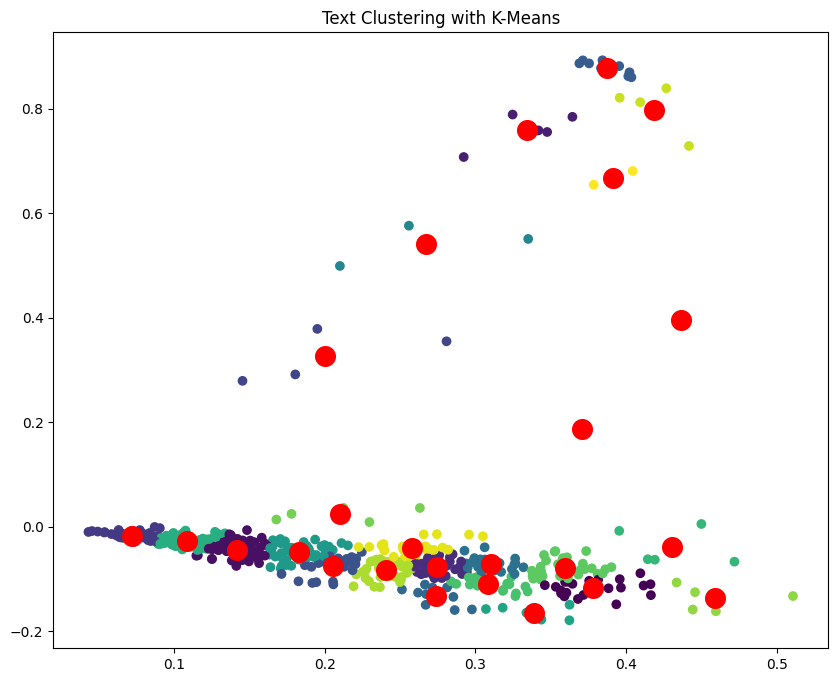

In [12]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd


# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['case_text'])

# Reduce dimensionality using LSA (Latent Semantic Analysis)
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Perform K-Means clustering
k = 25  # Number of clusters (based on the 25 agreements categories)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(lsa_matrix)

# Visualize the clusters
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1,], s=200, c='red')
plt.title("Text Clustering with K-Means")
plt.show()

In [13]:
categories = label_names = ['Affiliate Agreement', 'Agency Agreement', 'Collaboration/Cooperation Agreement',
'Co-Branding Advertising Agreement', 'Consulting Agreement','Development Agreement', 'Distributor Agreement',
'Endorsement Agreement', 'Franchise Agreement', 'Hosting Agreement', 'IP Agreement', 
'Joint Venture Agreement','License Agreement', 'Maintenance Agreement', 'Manufacturing Agreement',
'Marketing Agreement', 'Non-Compete/No-Solicit/Non-Disparagement Agreement','Outsourcing Agreement',
'Promotion Agreement', 'Reseller Agreement', 'Service Agreement', 'Sponsorship Agreement',
'Supply Agreement', 'Strategic Alliance Agreement', 'Transportation Agreement'
]


data = {'text': contracts}
df = pd.DataFrame(data)

In [14]:
df

,text
0,cobranding advertising agreementthis cobrandin...
1,exhibit information exhibit identified confid...
2,exhibit joint venture agreementcollectible co...
3,exhibit pursuant c.f.r. .24b2 confidential i...
4,redacted copyconfidential treatment requestedc...
...,...
505,exhibit .1intellectual property agreementthis ...
506,exhibit .2certain information indicated asteri...
507,exhibit first amendment sagebrush management ...
508,exhibit manufacturing design marketing agreem...


In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])


** Glove **

In [13]:
!pip install torchtext

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.9 MB 7.9 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/1.9 MB 9.0 MB/s eta 0:00:01
   ----------------------------- ---------- 1.4/1.9 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  1.9/1.9 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ----------- ---------------------------- 0.4/1.3 MB 8.1 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.3 MB 7.0 MB/s eta 0:00:01
   ------------------------------ --------- 1.0/1.3 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 6.5 MB/s eta 0:00:00


In [18]:
from torchtext.vocab import GloVe

embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100 
embedding_dim = 100

# define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

df['encode_glove'] = df['text'].apply(lambda sentence: sentence_embedding(sentence))
X_glove = np.vstack(df['encode_glove'])

** BERT **

In [19]:
# Load pre-trained BERT model and tokenizer
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

In [20]:
import time
import torch

st = time.time()

df['cls_bert'] = df['text'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_cls_bert = np.vstack(df['cls_bert'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 450.81 seconds


** Sentence Transformer **

Sentence Transformers are deep learning models that can encode natural language sentences into high-dimensional vector representations. They are trained using a pre-training and fine-tuning approach and have achieved state-of-the-art performance on several natural language processing tasks

In [23]:
pip install sentence-transformers


     ---------------------------------------- 0.0/86.0 kB ? eta -:--:--
     ---------------------------------------- 86.0/86.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB 8.6 MB/s eta 0:00:01
   ----------------- ---------------------- 0.5/1.1 MB 6.4 MB/s eta 0:00:01
   ----------------------- ---------------- 0.7/1.1 MB 5.9 MB/s eta 0:00:01
   ---------------------------- ----------- 0.8/1.1 MB 4.7 MB/s eta 0:00:01
   -------------------------------------- - 1.1/1.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 4.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125953 sha256=9579469fa6a21721dc8d62e4a466d5a1bca2b6155895330b12549b40da6d622a
  Stored in directory: c:\users\njoki\a

In [26]:
from sentence_transformers import SentenceTransformer 
st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['text'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df['encode_transforemers'])

Elapsed time: 27.98 seconds


**TF-IDF Vectorization**

In [28]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['text']).toarray()

**Clustering With K-Means**

K-Means partitions the data into K clusters based on their similarity

In [32]:
def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)
    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

In [42]:
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1

In [43]:
def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + Legal Agremeents clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

C:\Users\njoki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


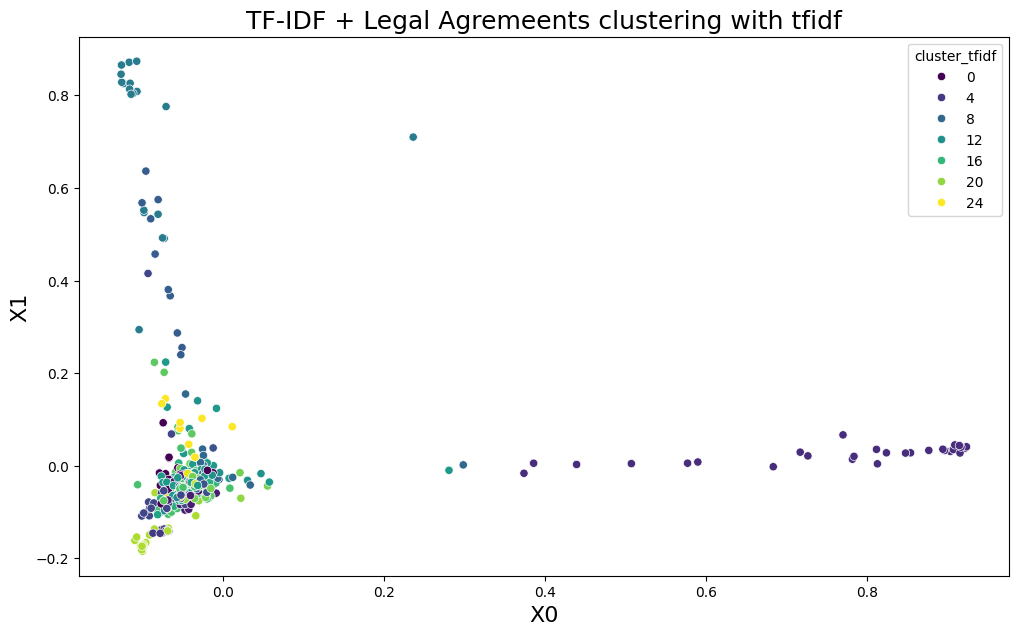

C:\Users\njoki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


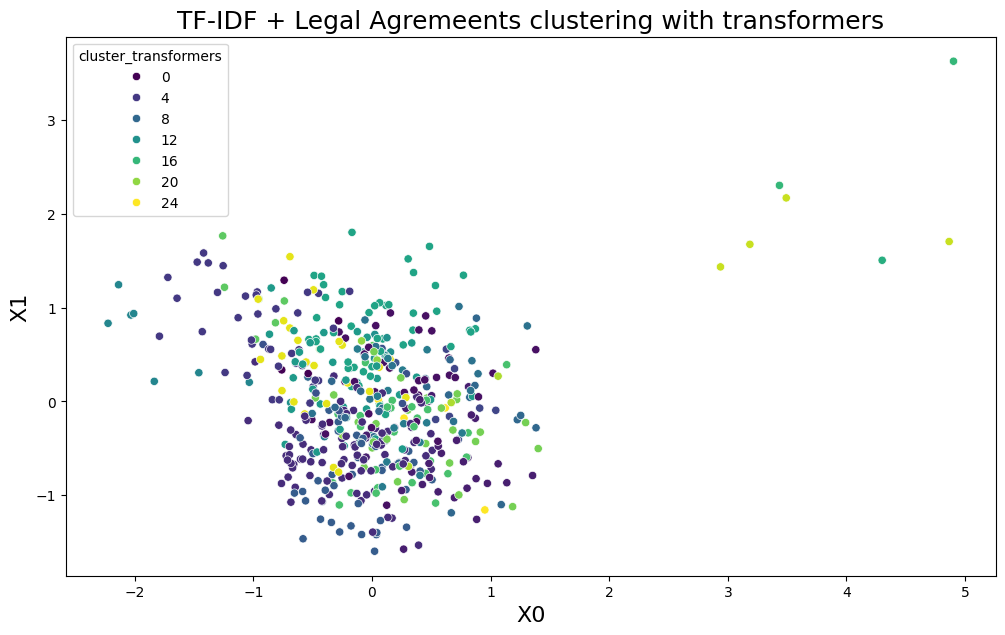

C:\Users\njoki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


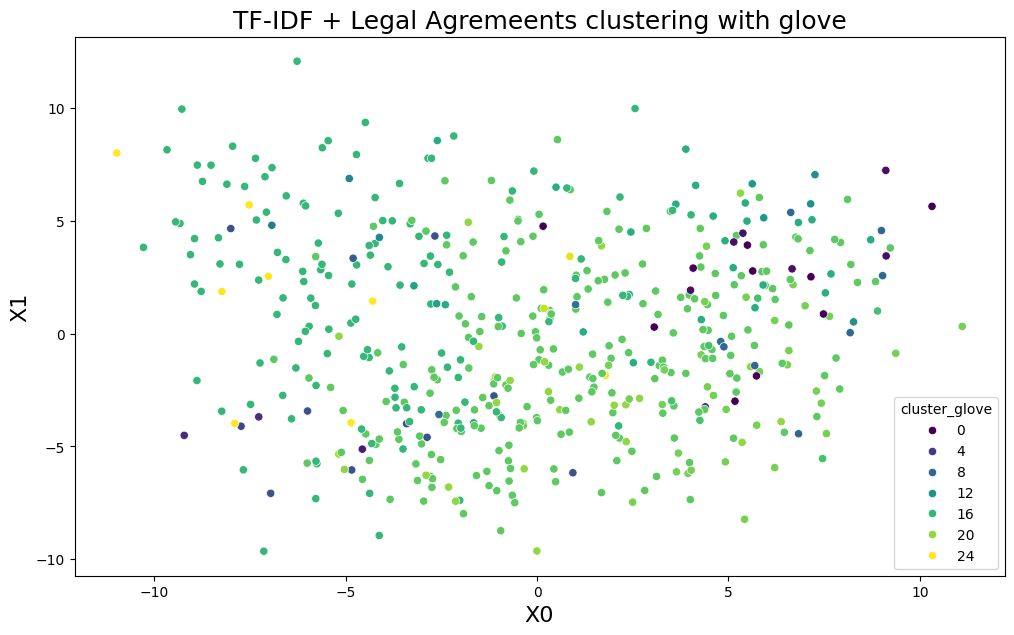

C:\Users\njoki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


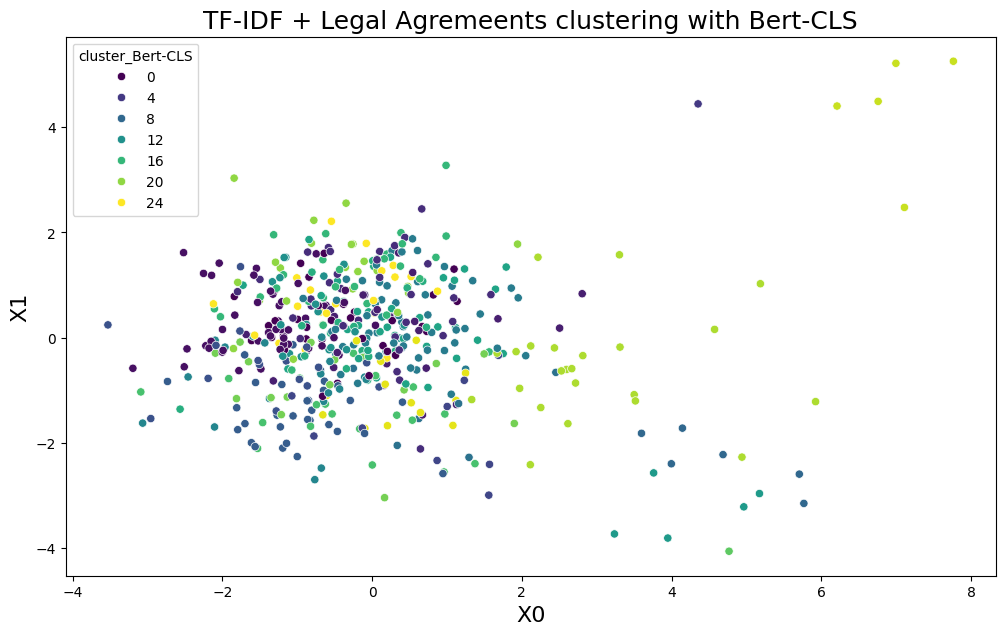

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns

for embedding_and_method in [(X, 'tfidf'), (X_transformers, 'transformers'), (X_glove, 'glove'), ((X_cls_bert, 'Bert-CLS')) ]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]
    
    # initialize kmeans with 25 centroids
    kmeans = KMeans(n_clusters=25, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_name = f'cluster_{method}'
    df[clusters_name] = clusters
    '''
    eval_cluster(embedding)
    '''
    
    dimension_reduction(embedding, method)
    
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_name, method=method)
    

In [ ]:
def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)
    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))